In [1]:
from typing import List
import os
import json
from glob import glob
from datetime import datetime
import random as rn
import time
import math

import numpy as np
import pandas as pd
from rich import print as rprint
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from minepy import MINE as Mine
from crypto_data_fetcher.gmo import GmoFetcher
from scipy.stats import ttest_1samp
import shap
import talib
from google.cloud import storage
from google.oauth2.service_account import Credentials
import numba
from tqdm.notebook import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, f1_score, r2_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
import joblib
import optuna

SECRET_KEY_PATH = '/Users/jo/gcp_secret_key2.json'
BAKET_NAME = 'trading_datas_storage2'
GCS_SAVE_DIR = 'trading_datas'
INPUT_DIR = 'trading_datas'
OUTPUT_DIR = 'features'

cred : Credentials = Credentials.from_service_account_info(json.load(open(SECRET_KEY_PATH)))
gcs_client : storage.Client = storage.Client(credentials=cred, project=cred.project_id)
gcs_bucket : storage.Bucket = gcs_client.get_bucket(BAKET_NAME)

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)


sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

np.random.seed(123)
rn.seed(123)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

KeyboardInterrupt: 

In [ ]:
!pwd

/Users/jo/GitHub/MLtrading/notebook/bybit_ordertable


# データ読み込み

In [3]:
# GCSからローカルに存在しないファイルをダウンロード

local_files = set([os.path.basename(path) for path in glob(os.path.join(INPUT_DIR, '*.pkl.bz2'))])
gcs_files = set([os.path.basename(file.name) for file in gcs_client.list_blobs(BAKET_NAME, prefix=GCS_SAVE_DIR)])

wanted_file_names = gcs_files - local_files  # 差集合
print('wanted_file_names: ')
print(wanted_file_names)

for filename in wanted_file_names:
    if filename == '':
        continue
    blob = gcs_bucket.blob(os.path.join(GCS_SAVE_DIR, filename))  # ストレージのパスを指定
    blob.download_to_filename(os.path.join(INPUT_DIR, filename))  # ダウンロード先のパスを指定

wanted_file_names: 
set()


In [3]:
def sort_by_datetime(pathlist: List[str]) -> List[str]:
    """ファイルパスのリストを日付によってソート"""

    def get_datetime(filename: str) -> str:
        """ファイル名の日付部分をdatetimeで返却"""
        date_str : str = os.path.basename(filename).split('_')[0]
        return datetime.strptime(date_str, '%Y%m%d')

    return sorted(pathlist, key=lambda x: get_datetime(x))

In [6]:
bybit_datas_pathlist = glob(os.path.join(INPUT_DIR, '*_bybit.pkl.bz2'))
bybit_datas_pathlist = sort_by_datetime(bybit_datas_pathlist)

df_bybit_list = [pd.read_pickle(path) for path in bybit_datas_pathlist]
df_bybit = pd.concat(df_bybit_list)

columns : List[str] = list(df_bybit.columns)

dtype_dict = {}
for column in columns:
    if column == 'timestamp':
        dtype_dict[column] = 'datetime64'
    elif column == 'orderbook':
        continue
    else:
        dtype_dict[column] = 'float64'


df_bybit = df_bybit.astype(dtype=dtype_dict)
df_bybit = df_bybit.fillna(method='bfill')
df_bybit = df_bybit.reset_index(drop=True)

print('created df')
display(df_bybit)

df_bybit.to_pickle('df_bybit.pkl')

created df


,timestamp,open,high,low,close,buy_volume,sell_volume,buy_price_avg,sell_price_avg,buy_liq_qty,sell_liq_qty,oi_open,oi_high,oi_low,oi_close,orderbook
0,2021-10-20 23:18:30.001663,65996.5,65997.0,65996.5,65996.5,5112.0,10977.0,129.102113,42.085770,0.0,0.0,1.969185e+09,1.969230e+09,1.969185e+09,1.969230e+09,"{'Buy': [{'price': '65996.50', 'size': 2362959..."
1,2021-10-20 23:18:35.000008,65997.0,65997.0,65996.5,65996.5,141948.0,208937.0,4.184441,2.842811,0.0,0.0,1.969230e+09,1.969259e+09,1.968839e+09,1.969259e+09,"{'Buy': [{'price': '65996.50', 'size': 1076854..."
2,2021-10-20 23:18:40.000002,65997.0,65997.0,65996.5,65997.0,40817.0,63913.0,21.019698,8.260792,0.0,0.0,1.969259e+09,1.969504e+09,1.969259e+09,1.969504e+09,"{'Buy': [{'price': '65996.50', 'size': 1562067..."
3,2021-10-20 23:18:45.000002,65996.5,65997.0,65996.5,65997.0,92649.0,13793.0,5.698669,28.708693,0.0,0.0,1.969504e+09,1.969535e+09,1.969504e+09,1.969535e+09,"{'Buy': [{'price': '65996.50', 'size': 1228344..."
4,2021-10-20 23:18:50.000005,65996.5,65997.0,65996.5,65997.0,14071.0,13244.0,14.070855,34.881871,0.0,0.0,1.969535e+09,1.969544e+09,1.969489e+09,1.969515e+09,"{'Buy': [{'price': '65996.50', 'size': 1290222..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244463,2021-12-31 23:59:35.186087,47983.5,47983.5,47983.5,47983.5,133.0,0.0,721.556391,21.382799,0.0,0.0,9.836653e+08,9.836654e+08,9.836653e+08,9.836654e+08,"{'Buy': [{'price': '47983.00', 'size': 2571797..."
1244464,2021-12-31 23:59:40.022507,47983.0,47983.5,47983.0,47983.5,10.0,2244.0,4798.350000,21.382799,0.0,0.0,9.836654e+08,9.836654e+08,9.836654e+08,9.836654e+08,"{'Buy': [{'price': '47983.00', 'size': 2219711..."
1244465,2021-12-31 23:59:45.125927,47983.5,47983.5,47983.5,47983.5,7.0,0.0,6854.785714,22.913961,0.0,0.0,9.836654e+08,9.836654e+08,9.836654e+08,9.836654e+08,"{'Buy': [{'price': '47983.00', 'size': 2368680..."
1244466,2021-12-31 23:59:50.126301,47983.0,47983.5,47979.5,47979.5,0.0,0.0,47981.750000,22.913961,0.0,0.0,9.836654e+08,9.836654e+08,9.836654e+08,9.836654e+08,"{'Buy': [{'price': '47983.00', 'size': 2038524..."


In [4]:
df = pd.read_pickle('df_bybit.pkl')
print('loaded df!')

loaded df!


In [24]:
def _cal_ask_bit_spread(row):
    best_bit = float(row['Buy'][0]['price'])
    best_ask = float(row['Sell'][0]['price'])
    return best_ask - best_bit

def _create_ask_bit_size_ratio(row):
    best_bit_size = float(row['Buy'][0]['size'])
    best_ask_size = float(row['Sell'][0]['size'])
    return np.log(best_ask_size / best_bit_size)

def cal_ba_spread_mean(df) -> float:
    spreads : NDArray[float] = np.vectorize(_cal_ask_bit_spread)(df['orderbook'])
    return np.mean(spreads)

def cal_ba_spread_std(df) -> float:
    spreads : NDArray[float] = np.vectorize(_cal_ask_bit_spread)(df['orderbook'])
    return np.std(spreads)

def cal_ba_ratio_mean(df) -> float:
    ratios : NDArray[float] = np.vectorize(_create_ask_bit_size_ratio)(df['orderbook'])
    return np.mean(ratios)

def cal_ba_ratio_std(df) -> float:
    ratios : NDArray[float] = np.vectorize(_create_ask_bit_size_ratio)(df['orderbook'])
    return np.std(ratios)


def convert_timescale2(df: pd.DataFrame, minute_interval: int) -> pd.DataFrame:
    df = df.copy()
    df_result = pd.DataFrame(columns=df.columns)
    i = 0
    while i < len(df):
        minute = df['timestamp'][i].minute
        if minute % minute_interval == 0:
            start_minute = minute
            start_idx = i+1
            for j in range(i+1, len(df)):
                if df['timestamp'][j].minute == start_minute + minute_interval:
                    end_idx = j
                    break
            df_s = df[start_idx:end_idx]
            record = {
            'timestamp': df_s['timestamp'].iloc[-1],
            'open': df_s['open'].iloc[0],
            'high': df_s['high'].max(),
            'low': df_s['low'].min(),
            'close': df_s['close'].iloc[-1],
            'buy_volume': df_s['buy_volume'].sum(),
            'sell_volume': df_s['sell_volume'].sum(),
            'buy_price_avg': df_s['buy_price_avg'].mean(),
            'sell_price_avg': df_s['sell_price_avg'].mean(),
            'buy_liq_qty': df_s['buy_liq_qty'].sum(),
            'sell_liq_qty': df_s['sell_liq_qty'].sum(),
            'oi_open': df_s['oi_open'].iloc[0],
            'oi_high': df_s['oi_high'].max(),
            'oi_low': df_s['oi_low'].min(),
            'oi_close': df_s['oi_close'].iloc[-1],
            'ba_spread_mean': cal_ba_spread_mean(df=df_s),
            'ba_spread_std': cal_ba_spread_std(df=df_s),
            'ba_ratio_mean': cal_ba_ratio_mean(df=df_s),
            'ba_ratio_std': cal_ba_ratio_std(df=df_s),
            }
            df_result = df_result.append(record, ignore_index=True)
            i = j + (24 * 5)  # 1分ほど進める
            print(start_idx, end_idx)
        else:
            i += 1

    return df_result


def convert_timescale3(df: pd.DataFrame, minute_interval: int) -> pd.DataFrame:
    df = df.copy()
    df_result = pd.DataFrame(columns=df.columns)
    timescale = minute_interval * 12
    i = 0
    while i < len(df):
        minute = df['timestamp'][i].minute
        if minute % minute_interval == 0:
            start_idx = i+1
            break
        else:
            i += 1

    for i in range(start_idx, len(df), timescale):
        try:
            df_s = df[i:i+timescale]
        except KeyError:
            break
        record = {
            'timestamp': df_s['timestamp'].iloc[-1],
            'open': df_s['open'].iloc[0],
            'high': df_s['high'].max(),
            'low': df_s['low'].min(),
            'close': df_s['close'].iloc[-1],
            'buy_volume': df_s['buy_volume'].sum(),
            'sell_volume': df_s['sell_volume'].sum(),
            'buy_price_avg': df_s['buy_price_avg'].mean(),
            'sell_price_avg': df_s['sell_price_avg'].mean(),
            'buy_liq_qty': df_s['buy_liq_qty'].sum(),
            'sell_liq_qty': df_s['sell_liq_qty'].sum(),
            'oi_open': df_s['oi_open'].iloc[0],
            'oi_high': df_s['oi_high'].max(),
            'oi_low': df_s['oi_low'].min(),
            'oi_close': df_s['oi_close'].iloc[-1],
            'ba_spread_mean': cal_ba_spread_mean(df=df_s),
            'ba_spread_std': cal_ba_spread_std(df=df_s),
            'ba_ratio_mean': cal_ba_ratio_mean(df=df_s),
            'ba_ratio_std': cal_ba_ratio_std(df=df_s),
            }
        df_result = df_result.append(record, ignore_index=True)
    return df_result


def convert_timescale(df: pd.DataFrame, timescale: int) -> pd.DataFrame:
    df = df.copy()
    df_result = pd.DataFrame(columns=df.columns)
    for i in tqdm(range(0, len(df), timescale)):
        try:
            df_s = df[i:i+timescale]
        except KeyError:
            break
        record = {
            'timestamp': df_s['timestamp'].iloc[-1],
            'open': df_s['open'].iloc[0],
            'high': df_s['high'].max(),
            'low': df_s['low'].min(),
            'close': df_s['close'].iloc[-1],
            'buy_volume': df_s['buy_volume'].sum(),
            'sell_volume': df_s['sell_volume'].sum(),
            'buy_price_avg': df_s['buy_price_avg'].mean(),
            'sell_price_avg': df_s['sell_price_avg'].mean(),
            'buy_liq_qty': df_s['buy_liq_qty'].sum(),
            'sell_liq_qty': df_s['sell_liq_qty'].sum(),
            'oi_open': df_s['oi_open'].iloc[0],
            'oi_high': df_s['oi_high'].max(),
            'oi_low': df_s['oi_low'].min(),
            'oi_close': df_s['oi_close'].iloc[-1],
            'ba_spread_mean': cal_ba_spread_mean(df=df_s),
            'ba_spread_std': cal_ba_spread_std(df=df_s),
            'ba_ratio_mean': cal_ba_ratio_mean(df=df_s),
            'ba_ratio_std': cal_ba_ratio_std(df=df_s),
            }
        df_result = df_result.append(record, ignore_index=True)
    return df_result

# df = pd.read_pickle('df_bybit.pkl')

print('loaded df!')

# df_15m = convert_timescale(df=df, timescale=12 * 15)
df_15m = convert_timescale3(df=df, minute_interval=15)
# df_1m = convert_timescale(df=df_bybit, timescale=12)
# df_2m = convert_timescale(df=df_bybit, timescale=24)
# df_5m = convert_timescale(df=df_bybit, timescale=12*5)
df_15m.to_pickle('df_bybit_15m2.pkl')

loaded df!


In [29]:
df_15m

,timestamp,open,high,low,close,buy_volume,sell_volume,buy_price_avg,sell_price_avg,buy_liq_qty,sell_liq_qty,oi_open,oi_high,oi_low,oi_close,orderbook,ba_ratio_mean,ba_ratio_std,ba_spread_mean,ba_spread_std
0,2021-10-20 23:45:00.049698,66205.5,66987.5,66205.5,66863.5,20428592.0,21071467.0,45.471744,411.997235,0.0,197097.0,1.966184e+09,1.992994e+09,1.965095e+09,1.986910e+09,NaN,-0.188074,2.307481,0.608333,0.922369
1,2021-10-21 00:00:00.000006,66863.5,67162.0,66735.5,66821.0,19901351.0,18490231.0,71.350519,1148.773305,37189.0,56707.0,1.986910e+09,2.012822e+09,1.985709e+09,1.997499e+09,NaN,-0.071937,2.554932,0.500000,0.000000
2,2021-10-21 00:15:00.000005,66821.0,67017.0,66720.0,66730.0,13383409.0,14349750.0,593.703409,630.151135,16797.0,0.0,1.997550e+09,2.012830e+09,1.997549e+09,1.997675e+09,NaN,0.205344,2.361172,0.500000,0.000000
3,2021-10-21 00:30:00.000266,66730.0,66838.0,66491.0,66740.5,15256482.0,16482294.0,584.336514,1307.714185,106582.0,0.0,1.997675e+09,2.027103e+09,1.996504e+09,2.026713e+09,NaN,0.465893,2.547208,0.500000,0.000000
4,2021-10-21 00:45:00.051460,66740.5,66947.0,66667.5,66826.5,10371742.0,10107916.0,624.042117,2439.372349,3079.0,0.0,2.026713e+09,2.050437e+09,2.004855e+09,2.043251e+09,NaN,-0.560466,2.174226,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6908,2021-12-31 23:00:50.139681,48047.0,48047.0,47932.0,47932.0,608821.0,999124.0,4321.717733,2123.600382,0.0,0.0,9.867780e+08,9.871584e+08,9.862791e+08,9.864397e+08,NaN,0.538857,2.115380,0.500000,0.000000
6909,2021-12-31 23:15:50.000007,47932.0,47960.5,47847.0,47901.5,1155161.0,1161071.0,7334.434200,5266.832042,0.0,0.0,9.864397e+08,9.887918e+08,9.839755e+08,9.840885e+08,NaN,0.724973,2.204546,0.500000,0.000000
6910,2021-12-31 23:30:50.001852,47901.0,48009.0,47854.0,47942.5,1773536.0,1055974.0,6525.018036,6664.807158,0.0,0.0,9.840885e+08,9.853276e+08,9.832291e+08,9.835720e+08,NaN,-0.410000,2.428119,0.505556,0.074328
6911,2021-12-31 23:45:50.159161,47943.0,48113.0,47940.5,47989.5,1677356.0,1105049.0,3734.831549,7887.086359,0.0,15326.0,9.835720e+08,9.858062e+08,9.835630e+08,9.836954e+08,NaN,-0.767120,2.250256,0.502778,0.037164


In [30]:
df = pd.read_pickle('df_bybit_15m2.pkl').dropna(axis=1)
df['volume'] = df['buy_volume'] + df['sell_volume']
df['fee'] = -0.00025
display(df)
df.to_pickle('df_ohlcv_with_fee.pkl')

df['timestamp'][0].minute % 5

,timestamp,open,high,low,close,buy_volume,sell_volume,buy_price_avg,sell_price_avg,buy_liq_qty,sell_liq_qty,oi_open,oi_high,oi_low,oi_close,ba_ratio_mean,ba_ratio_std,ba_spread_mean,ba_spread_std,volume,fee
0,2021-10-20 23:45:00.049698,66205.5,66987.5,66205.5,66863.5,20428592.0,21071467.0,45.471744,411.997235,0.0,197097.0,1.966184e+09,1.992994e+09,1.965095e+09,1.986910e+09,-0.188074,2.307481,0.608333,0.922369,41500059.0,-0.00025
1,2021-10-21 00:00:00.000006,66863.5,67162.0,66735.5,66821.0,19901351.0,18490231.0,71.350519,1148.773305,37189.0,56707.0,1.986910e+09,2.012822e+09,1.985709e+09,1.997499e+09,-0.071937,2.554932,0.500000,0.000000,38391582.0,-0.00025
2,2021-10-21 00:15:00.000005,66821.0,67017.0,66720.0,66730.0,13383409.0,14349750.0,593.703409,630.151135,16797.0,0.0,1.997550e+09,2.012830e+09,1.997549e+09,1.997675e+09,0.205344,2.361172,0.500000,0.000000,27733159.0,-0.00025
3,2021-10-21 00:30:00.000266,66730.0,66838.0,66491.0,66740.5,15256482.0,16482294.0,584.336514,1307.714185,106582.0,0.0,1.997675e+09,2.027103e+09,1.996504e+09,2.026713e+09,0.465893,2.547208,0.500000,0.000000,31738776.0,-0.00025
4,2021-10-21 00:45:00.051460,66740.5,66947.0,66667.5,66826.5,10371742.0,10107916.0,624.042117,2439.372349,3079.0,0.0,2.026713e+09,2.050437e+09,2.004855e+09,2.043251e+09,-0.560466,2.174226,0.500000,0.000000,20479658.0,-0.00025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6908,2021-12-31 23:00:50.139681,48047.0,48047.0,47932.0,47932.0,608821.0,999124.0,4321.717733,2123.600382,0.0,0.0,9.867780e+08,9.871584e+08,9.862791e+08,9.864397e+08,0.538857,2.115380,0.500000,0.000000,1607945.0,-0.00025
6909,2021-12-31 23:15:50.000007,47932.0,47960.5,47847.0,47901.5,1155161.0,1161071.0,7334.434200,5266.832042,0.0,0.0,9.864397e+08,9.887918e+08,9.839755e+08,9.840885e+08,0.724973,2.204546,0.500000,0.000000,2316232.0,-0.00025
6910,2021-12-31 23:30:50.001852,47901.0,48009.0,47854.0,47942.5,1773536.0,1055974.0,6525.018036,6664.807158,0.0,0.0,9.840885e+08,9.853276e+08,9.832291e+08,9.835720e+08,-0.410000,2.428119,0.505556,0.074328,2829510.0,-0.00025
6911,2021-12-31 23:45:50.159161,47943.0,48113.0,47940.5,47989.5,1677356.0,1105049.0,3734.831549,7887.086359,0.0,15326.0,9.835720e+08,9.858062e+08,9.835630e+08,9.836954e+08,-0.767120,2.250256,0.502778,0.037164,2782405.0,-0.00025


0

In [31]:
def up_hige_size(df):
    """上ヒゲの大きさ"""
    df = df.copy()
    uphige = np.zeros(len(df))
    high = df.high.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        h = high[i]
        o = open_[i]
        c = close[i]
        if sig == 1:
            uphige[i] = (h - o) / c
        else:
            uphige[i] = (h - c) / c
    uphige = uphige/close
    return uphige

def down_hige_size(df):
    """下ヒゲの大きさ"""
    df = df.copy()
    downhige = np.zeros(len(df))
    low = df.low.values
    close = df.close.values
    open_ = df.open.values
    # close とopenの高い方を判定
    close_or_open = df.open.values - df.close.values
    close_or_open_sign = np.sign(close_or_open)
    close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
    # 陽線
    for i in range(len(close_or_open_sign)):
        sig = close_or_open_sign[i]
        l = low[i]
        o = open_[i]
        c = close[i]

        if sig == 1:
            downhige[i] = (c - l) / c
        else:
            downhige[i] = (o - l) / c
    downhige = downhige/close
    return downhige


def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    df['pct'] = df['close'].pct_change()  # 変化率
    # 平均足を使った戦略: https://note.com/btcml/n/n6198a3714fe5
    df['heikin_cl'] = 0.25 * (df['open'] + df['high'] + df['low'] + df['close'])
    df['heikin_op'] = df['heikin_cl'].ewm(1, adjust=False).mean().shift(1)
    # for span in [5, 15, 25]:
    #     df[f'pct_mean{span}']= df['pct'].rolling(span).mean()  # 変化率の偏差
    #     df[f'pct_std{span}']= df['pct'].rolling(span).std()  # 変化率の偏差
    #     df[f'heikin_cl_mean{span}'] = df['heikin_cl'].rolling(span).mean()
    #     df[f'heikin_cl_std{span}'] = df['heikin_cl'].rolling(span).std()
    #     df[f'heikin_op_mean{span}'] = df['heikin_op'].rolling(span).mean()
    #     df[f'heikin_op_std{span}'] = df['heikin_op'].rolling(span).std()

    df['bs_volume_ratio'] = np.log(df['buy_volume'] / df['sell_volume'])

    return df


df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = calc_features(df)

df = df.set_index('timestamp')


display(df)

print('NaNが含まれている行数:', df.isnull().any(axis=1).sum())

df.to_pickle('df_features.pkl')

,open,high,low,close,buy_volume,sell_volume,buy_price_avg,sell_price_avg,buy_liq_qty,sell_liq_qty,oi_open,oi_high,oi_low,oi_close,ba_ratio_mean,ba_ratio_std,ba_spread_mean,ba_spread_std,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,uphige_size,downhige_size,pct,heikin_cl,heikin_op,bs_volume_ratio
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-20 23:45:00.049698,66205.5,66987.5,66205.5,66863.5,20428592.0,21071467.0,45.471744,411.997235,0.0,197097.0,1.966184e+09,1.992994e+09,1.965095e+09,1.986910e+09,-0.188074,2.307481,0.608333,0.922369,41500059.0,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.841432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.833891e+07,NaN,4.150006e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.773598e-08,0.000000e+00,NaN,66565.500,NaN,-0.030984
2021-10-21 00:00:00.000006,66863.5,67162.0,66735.5,66821.0,19901351.0,18490231.0,71.350519,1148.773305,37189.0,56707.0,1.986910e+09,2.012822e+09,1.985709e+09,1.997499e+09,-0.071937,2.554932,0.500000,0.000000,38391582.0,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.099648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.339972e+06,NaN,3.108477e+06,NaN,NaN,426.5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.685261e-08,1.914874e-08,-0.000636,66895.500,66565.50000,0.073545
2021-10-21 00:15:00.000005,66821.0,67017.0,66720.0,66730.0,13383409.0,14349750.0,593.703409,630.151135,16797.0,0.0,1.997550e+09,2.012830e+09,1.997549e+09,1.997675e+09,0.205344,2.361172,0.500000,0.000000,27733159.0,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.306397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.052563e+07,NaN,-2.462468e+07,NaN,NaN,297.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.401633e-08,2.245731e-09,-0.001362,66822.000,66730.50000,-0.069717
2021-10-21 00:30:00.000266,66730.0,66838.0,66491.0,66740.5,15256482.0,16482294.0,584.336514,1307.714185,106582.0,0.0,1.997675e+09,2.027103e+09,1.996504e+09,2.026713e+09,0.465893,2.547208,0.500000,0.000000,31738776.0,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.622770e+06,NaN,7.114094e+06,NaN,NaN,347.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.188899e-08,5.365609e-08,0.000157,66699.875,66776.25000,-0.077282
2021-10-21 00:45:00.051460,66740.5,66947.0,66667.5,66826.5,10371742.0,10107916.0,624.042117,2439.372349,3079.0,0.0,2.026713e+09,2.050437e+09,2.004855e+09,2.043251e+09,-0.560466,2.174226,0.500000,0.000000,20479658.0,-0.00025,93.154947,-10.95,-115.054947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.801779e+06,NaN,2.759375e+07,NaN,NaN,279.5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,52.052474,2.698296e-08,1.634652e-08,0.001289,66795.375,66738.06250,0.025766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

NaNが含まれている行数: 88


In [32]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    # 'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    # 'LINEARREG_INTERCEPT',
    # 'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',

    'pct',
    'uphige_size',
    'downhige_size',

    'heikin_cl',
    'heikin_op',

    'bs_volume_ratio',
    'buy_liq_qty',
    'sell_liq_qty',
    'ba_spread_mean',
    'ba_spread_std',
    'ba_ratio_mean',
    'ba_ratio_std',
    'oi_close',
])


print(features)
print('num of features', len(features))

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA', 'ba_ratio_mean', 'ba_ratio_std', 'ba_spread_mean', 'ba_spread_std', 'bs_volume_ratio', 'buy_liq_qty', 'downhige_size', 'heikin_cl', 'heikin_op', 'oi_close', 'pct', 'sell_liq_qty', 'uphige_size']
num of features 53


In [34]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

In [61]:
def calc_y(df,param):
    # 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
    pips = 0.5

    # ATRで指値距離を計算します
    limit_price_dist = df['ATR'] * param['atr']
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['close'] - limit_price_dist
    df['sell_price'] = df['close'] + limit_price_dist

    #df['buy_price'] = df['cl'] + df['BBANDS_lowerband'] 
    #df['sell_price'] = df['cl'] + limit_price_dist 

    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['high'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1

    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料

    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

    # yを計算
    df['y_buy'] = df['sell_fep'].shift(-horizon) / df['buy_fep'] - 1 - 2 * fee
    
    # df['y_buy'] = np.where(
    #     df['buy_executed'],
    #     df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    #     0
    # )
    df['y_sell'] = -(df['buy_fep'].shift(-horizon) / df['sell_fep'] - 1) - 2 * fee

    # df['y_sell'] = np.where(
    #     df['sell_executed'],
    #     -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    #     0
    # )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['close'] - 1) + fee,
        0
    )
    return df

df_features = pd.read_pickle('df_features.pkl')
def objective(trial):
    atr = trial.suggest_uniform('atr', 0.0, 2.0)
    param = {"atr":atr}
    df = calc_y(df_features,param)
    # score = df['y_buy'].cumsum().iloc[-1] + df['y_sell'].cumsum().iloc[-1]
    score = df['y_buy'].cumsum().iloc[-1]
    # score = df['y_sell'].cumsum().iloc[-1]
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
# プログラムが試行錯誤した結果最も良いパラメータを表示
print("best param: {}".format(study.best_params))
# 最も良いパラメータで実行したときの結果（返り値）を表示
print("best score: {}".format(study.best_value))

[I 2022-01-01 22:26:57,241] A new study created in memory with name: no-name-bac13796-d981-49a8-9115-60690bc800f3
[W 2022-01-01 22:26:57,518] Trial 0 failed, because the objective function returned nan.
[W 2022-01-01 22:26:57,557] Trial 1 failed, because the objective function returned nan.
[W 2022-01-01 22:26:57,602] Trial 2 failed, because the objective function returned nan.
[W 2022-01-01 22:26:57,671] Trial 3 failed, because the objective function returned nan.
[W 2022-01-01 22:26:57,731] Trial 4 failed, because the objective function returned nan.
[W 2022-01-01 22:26:57,803] Trial 5 failed, because the objective function returned nan.
[W 2022-01-01 22:26:57,969] Trial 6 failed, because the objective function returned nan.
[W 2022-01-01 22:26:58,030] Trial 7 failed, because the objective function returned nan.
[W 2022-01-01 22:26:58,084] Trial 8 failed, because the objective function returned nan.
[W 2022-01-01 22:26:58,156] Trial 9 failed, because the objective function returned n

ValueError: No trials are completed yet.

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


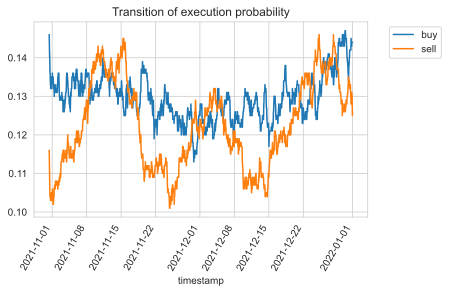

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


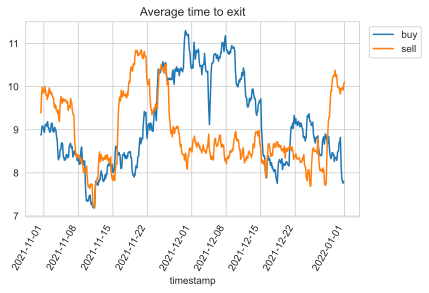

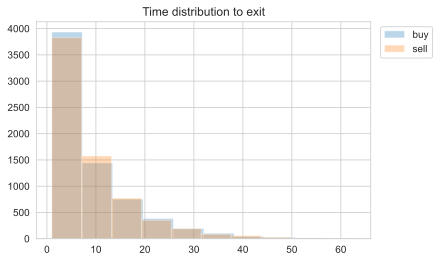

毎時刻、この執行方法でトレードした場合の累積リターン


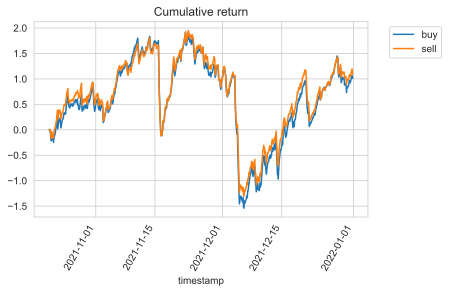

In [65]:
df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.5

# ATRで指値距離を計算します
# limit_price_dist = df['ATR'] * 0.5
limit_price_dist = df['ATR'] * 1.04
# limit_price_dist = df['ATR'] * 1.93
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = df['sell_fep'].shift(-horizon) / df['buy_fep'] - 1 - 2 * fee

# df['y_buy'] = np.where(
#     df['buy_executed'],
#     df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
#     0
# )

df['y_sell'] = -(df['buy_fep'].shift(-horizon) / df['sell_fep'] - 1) - 2 * fee

# df['y_sell'] = np.where(
#     df['sell_executed'],
#     -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
#     0
# )

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_executed'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Transition of execution probability')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_fet'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Average time to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('Time distribution to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy', rot=60)
df['y_sell'].cumsum().plot(label='sell', rot=60)
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

In [66]:
def show_lgb_feature_importances(lgb_model):
    ranking = np.argsort(-lgb_model.feature_importances_)  # 重要度のindexを降順で取得
    f, ax = plt.subplots(figsize=(15, 20))
    var_ = []
    for index in ranking:
        var_.append(features[index])
    # x は特徴量の重要度
    # yは特徴量の名前
    sns.barplot(x=lgb_model.feature_importances_[ranking], y =var_, orient='h')
    ax.set_xlabel("lightGBM feature importance")
    plt.tight_layout()
    plt.show()
    return var_


# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)


def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)


def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred


def show_cum_ret(df):
    # df[(df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)]['y_buy'].cumsum().plot(label='buy', rot=60)
    df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(rot=60, title='buy', color=colors[1])
    plt.show()
    # df[(df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0)]['y_sell'].cumsum().plot(label='sell', rot=60)
    df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(rot=60, title='sell', color=colors[0])
    plt.show()
    # (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum().plot(label='buy + sell', rot=60)
    (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(rot=60, title='buy + sell', color=colors[2])
    plt.show()

    # df['cum_ret'] = (df['y_buy'] * ((df['y_pred_buy'] > 0) & (df['y_pred_sell'] < 0)) + df['y_sell'] * ((df['y_pred_buy'] < 0) & (df['y_pred_sell'] > 0))).cumsum()
    df['cum_ret'] = (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = len(df) // (2 * 7 * 24 * 4)  # 2週間分 
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


def show_cum_ret_sell(df):
    df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(rot=60, title='sell', color=colors[0])
    plt.show()

    df['cum_ret'] = (df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum()
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = len(df) // (2 * 7 * 24 * 4)  # 2週間分 
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


def show_cum_ret_buy(df):
    df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(rot=60, title='buy', color=colors[1])
    plt.show()

    df['cum_ret'] = (df['y_buy'] * (df['y_pred_buy'] > 0))
    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = len(df) // (2 * 7 * 24 * 4)  # 2週間分 
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

6913
6807


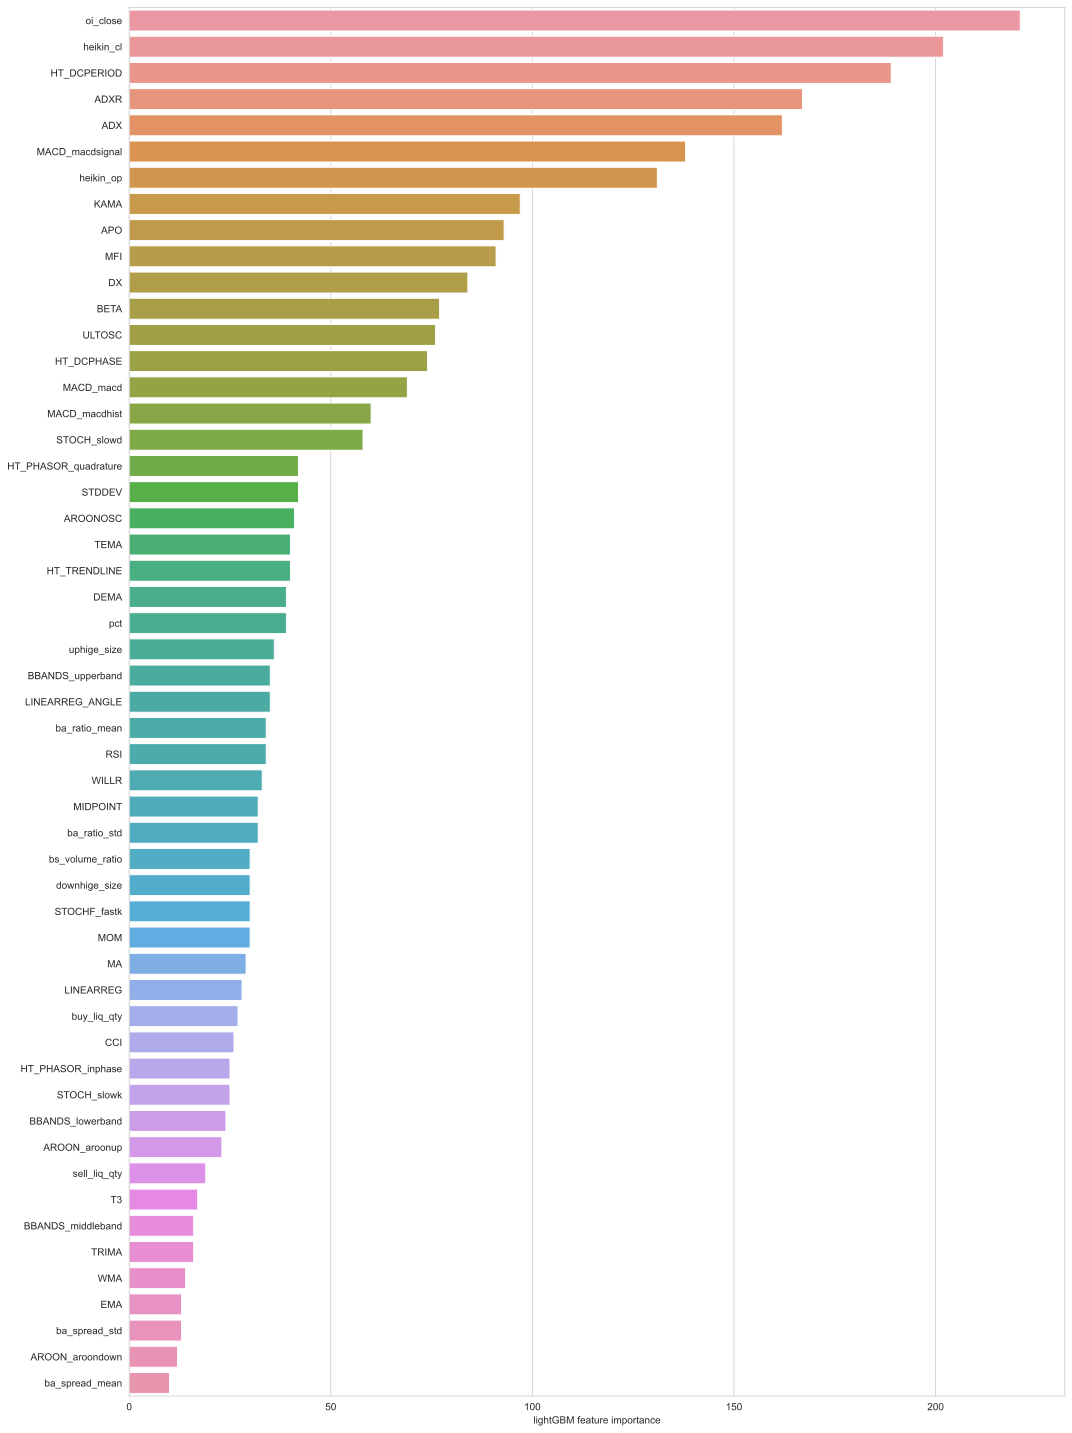

In [67]:
df = pd.read_pickle('df_y.pkl')
print(len(df))
df = df.dropna()
print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

# 通常のCV
cv_indicies = list(KFold().split(df))

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
# df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)


# 予測値が無い(nan)行をドロップ
df = df.dropna()

df.to_pickle('df_fit.pkl')

sorted_features = show_lgb_feature_importances(lgb_model=model)

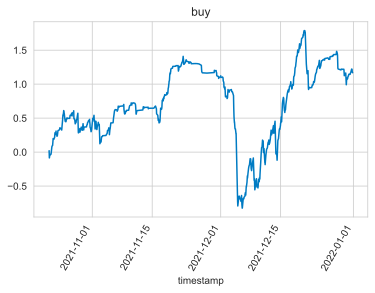

p平均法 n = 5
p平均 1.0
エラー率 26.041666666666668


In [68]:
df = pd.read_pickle('df_fit.pkl')

# show_cum_ret_sell(df=df)
show_cum_ret_buy(df=df)

In [69]:
@numba.njit
def backtest(
    cl=None, hi=None, lo=None, pips=None,
    buy_entry=None, sell_entry=None,
    buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]  # 既にエントリ済みならエントリしない
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]  # 既にエントリ済みならエントリしない
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            # 実際の指値は終値からいくらかずらした値(ATRを使って終値からずらした指値)だった。
            # つまり、実際は終値よりもちょっとだけ良い値段でエントリしたり決済したはず、その分を先にcostとして計算しておき、後にまとめて調整する仕組み。
            # costと呼んでいるが、実際には終値からの調整幅を記録した値、と考えるとすっきりしそう。
            # ポジションがある限り終値の差分を計算していくので、含み益、あるいは含み損を持ち越している。
            # また、決済の指値は機械学習の判定は関係なく常に出している。
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

def show_test_result(df):
    df = df.copy()

    df['cum_ret'].plot(rot=60)
    plt.title('Cumulative return')
    plt.show()

    print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
    print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
    df['poss'].plot(rot=60)
    plt.title('Position Changes')
    plt.show()

    print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
    df['poss'].rolling(1000).mean().plot(rot=60)
    plt.title('Changes in position averages')
    plt.show()

    print('取引量(ポジション差分の絶対値)の累積です。')
    print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
    df['poss'].diff(1).abs().dropna().cumsum().plot(rot=60)
    plt.title('Cumulative trading volume')
    plt.show()

    print('t検定')
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0)
    print('t値 {}'.format(t))
    print('p値 {}'.format(p))

    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = len(df) // (2 * 7 * 24 * 4)  # 2週間分 
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

    print('result: ', df['cum_ret'][-1])

In [70]:
@numba.njit
def backtest_sell(
    cl=None, hi=None, lo=None, pips=None,
    buy_entry=None, sell_entry=None,
    buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        # if sell_cost[i]:
        #     vol = np.maximum(0, prev_pos)
        #     ret -= sell_cost[i] * vol
        #     pos -= vol

        # entry
        # if buy_entry[i] and buy_cost[i]:
        #     vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]  # 既にエントリ済みならエントリしない
        #     ret -= buy_cost[i] * vol
        #     pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]  # 既にエントリ済みならエントリしない
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            # 実際の指値は終値からいくらかずらした値(ATRを使って終値からずらした指値)だった。
            # つまり、実際は終値よりもちょっとだけ良い値段でエントリしたり決済したはず、その分を先にcostとして計算しておき、後にまとめて調整する仕組み。
            # costと呼んでいるが、実際には終値からの調整幅を記録した値、と考えるとすっきりしそう。
            # ポジションがある限り終値の差分を計算していくので、含み益、あるいは含み損を持ち越している。
            # また、決済の指値は機械学習の判定は関係なく常に出している。
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

def show_test_result_sell(df):
    df = df.copy()

    df['cum_ret'].plot(rot=60)
    plt.title('Cumulative return')
    plt.show()

    print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
    print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
    df['poss'].plot(rot=60)
    plt.title('Position Changes')
    plt.show()

    print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
    df['poss'].rolling(1000).mean().plot(rot=60)
    plt.title('Changes in position averages')
    plt.show()

    print('取引量(ポジション差分の絶対値)の累積です。')
    print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
    df['poss'].diff(1).abs().dropna().cumsum().plot(rot=60)
    plt.title('Cumulative trading volume')
    plt.show()

    print('t検定')
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0)
    print('t値 {}'.format(t))
    print('p値 {}'.format(p))

    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = len(df) // (2 * 7 * 24 * 4)  # 2週間分 
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

    print('result: ', df['cum_ret'][-1])

In [71]:
@numba.njit
def backtest_buy(
    cl=None, hi=None, lo=None, pips=None,
    buy_entry=None, sell_entry=None,
    buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        # if buy_cost[i]:
        #     vol = np.maximum(0, -prev_pos)
        #     ret -= buy_cost[i] * vol
        #     pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]  # 既にエントリ済みならエントリしない
            ret -= buy_cost[i] * vol
            pos += vol

        # if sell_entry[i] and sell_cost[i]:
        #     vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]  # 既にエントリ済みならエントリしない
        #     ret -= sell_cost[i] * vol
        #     pos -= vol
        
        if i + 1 < n:
            # 実際の指値は終値からいくらかずらした値(ATRを使って終値からずらした指値)だった。
            # つまり、実際は終値よりもちょっとだけ良い値段でエントリしたり決済したはず、その分を先にcostとして計算しておき、後にまとめて調整する仕組み。
            # costと呼んでいるが、実際には終値からの調整幅を記録した値、と考えるとすっきりしそう。
            # ポジションがある限り終値の差分を計算していくので、含み益、あるいは含み損を持ち越している。
            # また、決済の指値は機械学習の判定は関係なく常に出している。
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

def show_test_result_buy(df):
    df = df.copy()

    df['cum_ret'].plot(rot=60)
    plt.title('Cumulative return')
    plt.show()

    print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
    print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
    df['poss'].plot(rot=60)
    plt.title('Position Changes')
    plt.show()

    print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
    df['poss'].rolling(1000).mean().plot(rot=60)
    plt.title('Changes in position averages')
    plt.show()

    print('取引量(ポジション差分の絶対値)の累積です。')
    print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
    df['poss'].diff(1).abs().dropna().cumsum().plot(rot=60)
    plt.title('Cumulative trading volume')
    plt.show()

    print('t検定')
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0)
    print('t値 {}'.format(t))
    print('p値 {}'.format(p))

    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = len(df) // (2 * 7 * 24 * 4)  # 2週間分 
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))
    print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

    print('result: ', df['cum_ret'][-1])

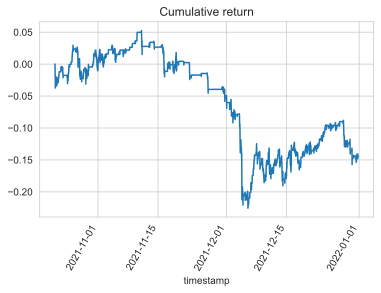

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


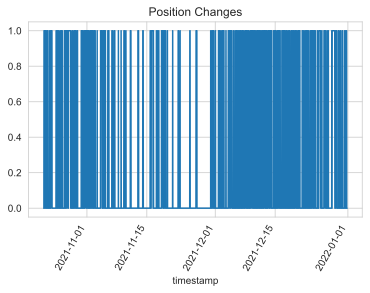

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


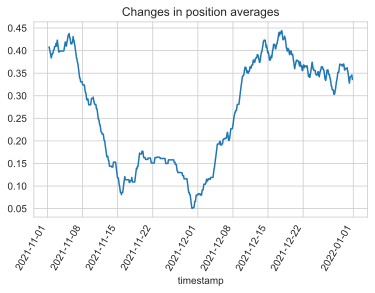

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


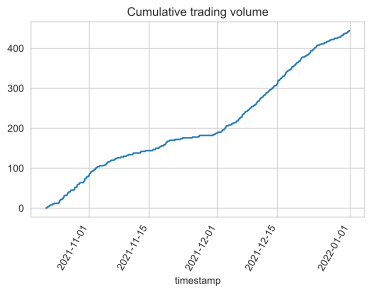

t検定
t値 -0.8650096533722654
p値 0.3870639821030901
p平均法 n = 5
p平均 0.9689851732717013
エラー率 22.246128156693697
result:  -0.1440433893855958


In [72]:
df = pd.read_pickle('df_fit.pkl')

# df['cum_ret'], df['poss'] = backtest_sell(
#     cl=df['close'].values,
#     buy_entry=None,
#     sell_entry=df['y_pred_sell'].values > 0,
#     buy_cost=df['buy_cost'].values,
#     sell_cost=df['sell_cost'].values,
# )
# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest_buy(
    cl=df['close'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=None,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)
show_test_result_sell(df=df)

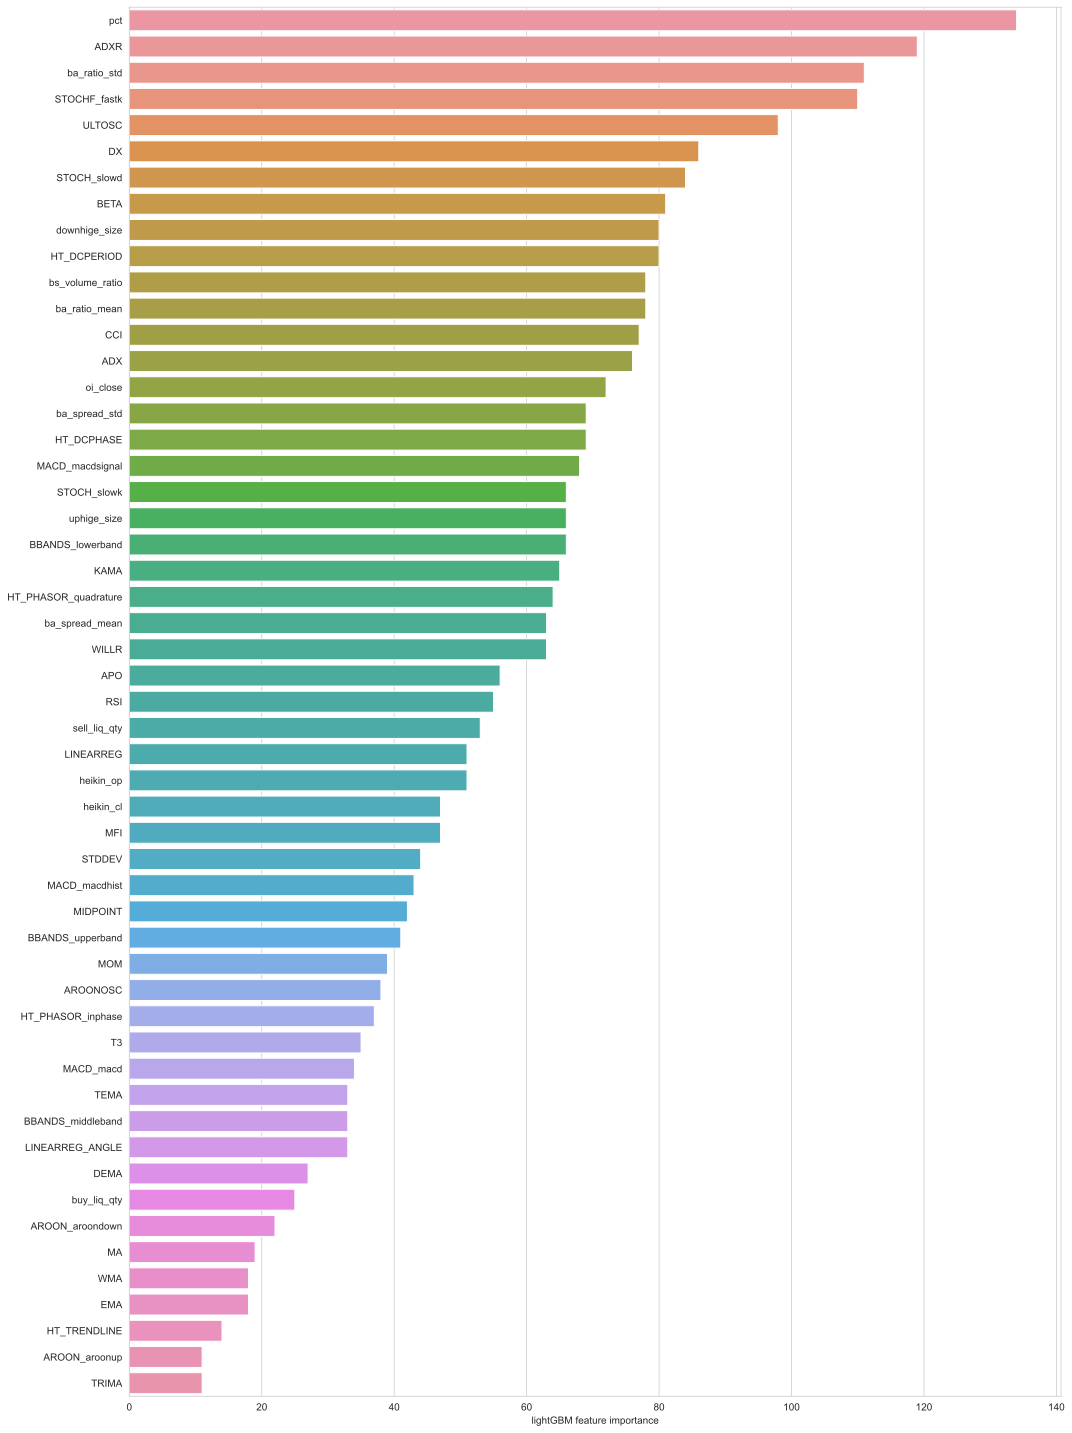

In [51]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()
df = df.reset_index()

train_ratio = 0.75
# train_ratio = 0.95
df_train = df.loc[:len(df)*train_ratio]
df_test = df.loc[len(df)*train_ratio + 5:]


# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, random_state=1)
# model = lgb.LGBMRegressor(boosting_type='goss', n_jobs=-1, random_state=1)

def model_predict(estimator, X_train, y_train, X_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return y_pred

df = df_test.copy()

# df['y_pred_buy'] = model_predict(model, df_train[features].values, df_train['y_buy'].values, df_test[features])
df['y_pred_sell'] = model_predict(model, df_train[features].values, df_train['y_sell'].values, df_test[features])

# 予測値が無い(nan)行をドロップ
df = df.dropna().set_index('timestamp')
df.to_pickle('df_fit_test.pkl')
sorted_features = show_lgb_feature_importances(lgb_model=model)

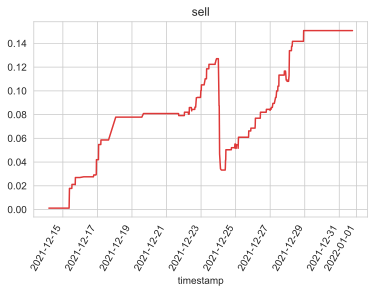

p平均法 n = 1
p平均 0.04515652770812099
エラー率 0.04515652770812099


In [52]:
df = pd.read_pickle('df_fit_test.pkl')

# show_cum_ret_buy(df=df)
show_cum_ret_sell(df=df)

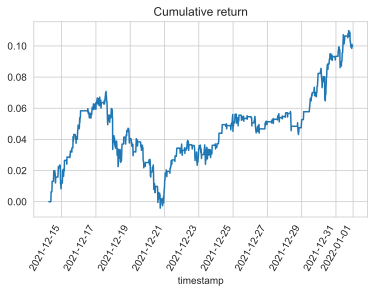

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


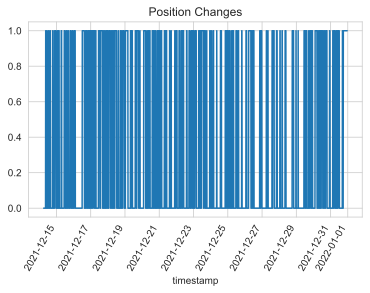

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


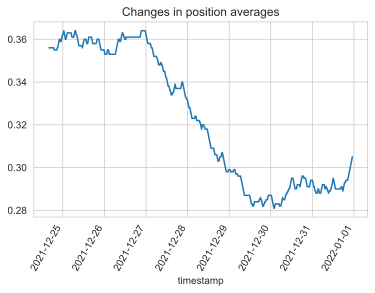

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


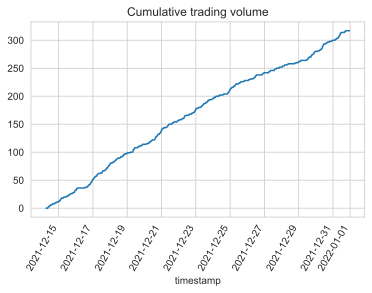

t検定
t値 1.3892957550796654
p値 0.16492498800253774
p平均法 n = 1
p平均 0.16492498800253774
エラー率 0.16492498800253774
result:  0.09962717455942674


In [119]:
df = pd.read_pickle('df_fit_test.pkl')

# バックテストで累積リターンと、ポジションを計算
# df['cum_ret'], df['poss'] = backtest_sell(
#     cl=df['close'].values,
#     buy_entry=None,
#     sell_entry=df['y_pred_sell'].values > 0,
#     buy_cost=df['buy_cost'].values,
#     sell_cost=df['sell_cost'].values,
# )
# show_test_result_sell(df=df)

df['cum_ret'], df['poss'] = backtest_buy(
    cl=df['close'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=None,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)
show_test_result_buy(df=df)